<a href="https://colab.research.google.com/github/solankybasant/Generative-Models/blob/main/Generative_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Basnat Solanky \\
Roll No. : 12040430 \\
References: https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Creating a Sampling Layer
#Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


<center><h2>Build Encoder

In [ ]:
latent_dim = 40

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 4, activation="elu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 4, activation="elu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   544         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     32832       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

<center><h3>Build Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(1024, activation='elu')(latent_inputs)
x1 = layers.Dense(128, activation="elu")(x)
x2 = layers.Dense(128, activation="elu")(x1)
x3 = layers.Dense(128, activation="elu")(tf.concat([x2, x], 1))
x = layers.Dense(7 * 7 * 64, activation="elu")(x3)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="elu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(32, 7, activation="elu", strides=4, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 1024)         41984       ['input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 128)          131200      ['dense_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 128)          16512       ['dense_4[0][0]']                
                                                                                            

<center><h3>Define the VAE as a 'Model' with a custom 'train_step'

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

<center><h3>Loading the Dataset

In [ ]:
Car = np.load('/content/drive/MyDrive/ML/Asg6/full_numpy_bitmap_car.npy')
AircraftCarrier = np.load('/content/drive/MyDrive/ML/Asg6/full_numpy_bitmap_aircraft carrier.npy')
Bicycle = np.load('/content/drive/MyDrive/ML/Asg6/full_numpy_bitmap_bicycle.npy')
Bus = np.load('/content/drive/MyDrive/ML/Asg6/full_numpy_bitmap_bus.npy')
Truck = np.load('/content/drive/MyDrive/ML/Asg6/full_numpy_bitmap_truck.npy')


<center><h3> Task 1

In [ ]:
Car = Car.astype('float32')/255
AircraftCarrier = AircraftCarrier.astype('float32')/255
Bicycle = Bicycle.astype('float32')/255
Bus = Bus.astype('float32')/255
Truck = Truck.astype('float32')/255

X = np.concatenate((AircraftCarrier, Bicycle, Bus, Car, Truck), axis=0)
X = X
y = np.array([0]*len(AircraftCarrier) + [1]*len(Bicycle) +[2]*len(Bus) + [3]*len(Car) + [4]*len(Truck))

del AircraftCarrier, Bicycle, Bus, Car, Truck

indicies = np.arange(len(X))
np.random.shuffle(indicies)
X = X[indicies]
y = y[indicies]

X_train = X[:]

X_train=X_train.reshape((len(X_train), 28, 28, 1))

del X

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
tsne = TSNE(n_components=2, verbose=1, random_state=123)
N=100000
z = tsne.fit_transform(X_train[:N].reshape((N, 784))) 
df = pd.DataFrame()
df["y"] = y[:N]
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.057s...
[t-SNE] Computed neighbors for 100000 samples in 451.497s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

[Text(0.5, 1.0, 'QuickDraw t-SNE')]

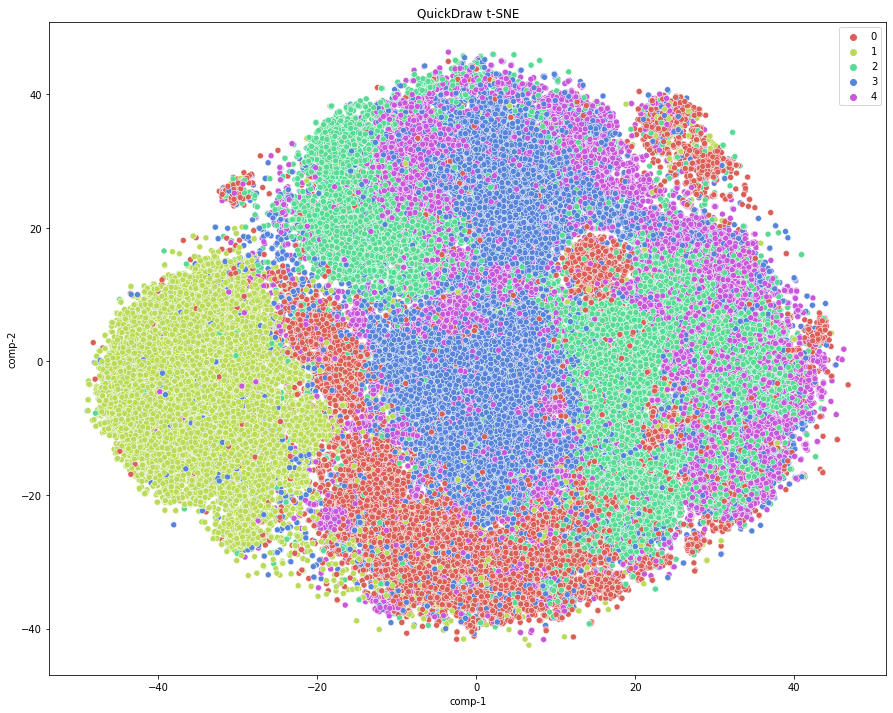

In [ ]:
plt.figure(figsize=(15,12))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 5),
                data=df).set(title="QuickDraw t-SNE") 

<center><h3>Training the VAE





In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
history = vae.fit(X_train, epochs=15 , batch_size=4096)

Epoch 1/15
177/177 [==============================] - 51s 224ms/step - loss: 311.6607 - reconstruction_loss: 256.6474 - kl_loss: 4.5051
Epoch 2/15
177/177 [==============================] - 41s 231ms/step - loss: 218.6932 - reconstruction_loss: 202.8139 - kl_loss: 11.0244
Epoch 3/15
177/177 [==============================] - 41s 229ms/step - loss: 204.1823 - reconstruction_loss: 187.6138 - kl_loss: 14.3975
Epoch 4/15
177/177 [==============================] - 41s 229ms/step - loss: 196.9175 - reconstruction_loss: 179.5532 - kl_loss: 16.2799
Epoch 5/15
177/177 [==============================] - 41s 231ms/step - loss: 192.3780 - reconstruction_loss: 174.5060 - kl_loss: 17.3813
Epoch 6/15
177/177 [==============================] - 41s 230ms/step - loss: 190.6795 - reconstruction_loss: 171.4917 - kl_loss: 18.2444
Epoch 7/15
177/177 [==============================] - 41s 231ms/step - loss: 187.9376 - reconstruction_loss: 168.5928 - kl_loss: 18.9841
Epoch 8/15
177/177 [======================

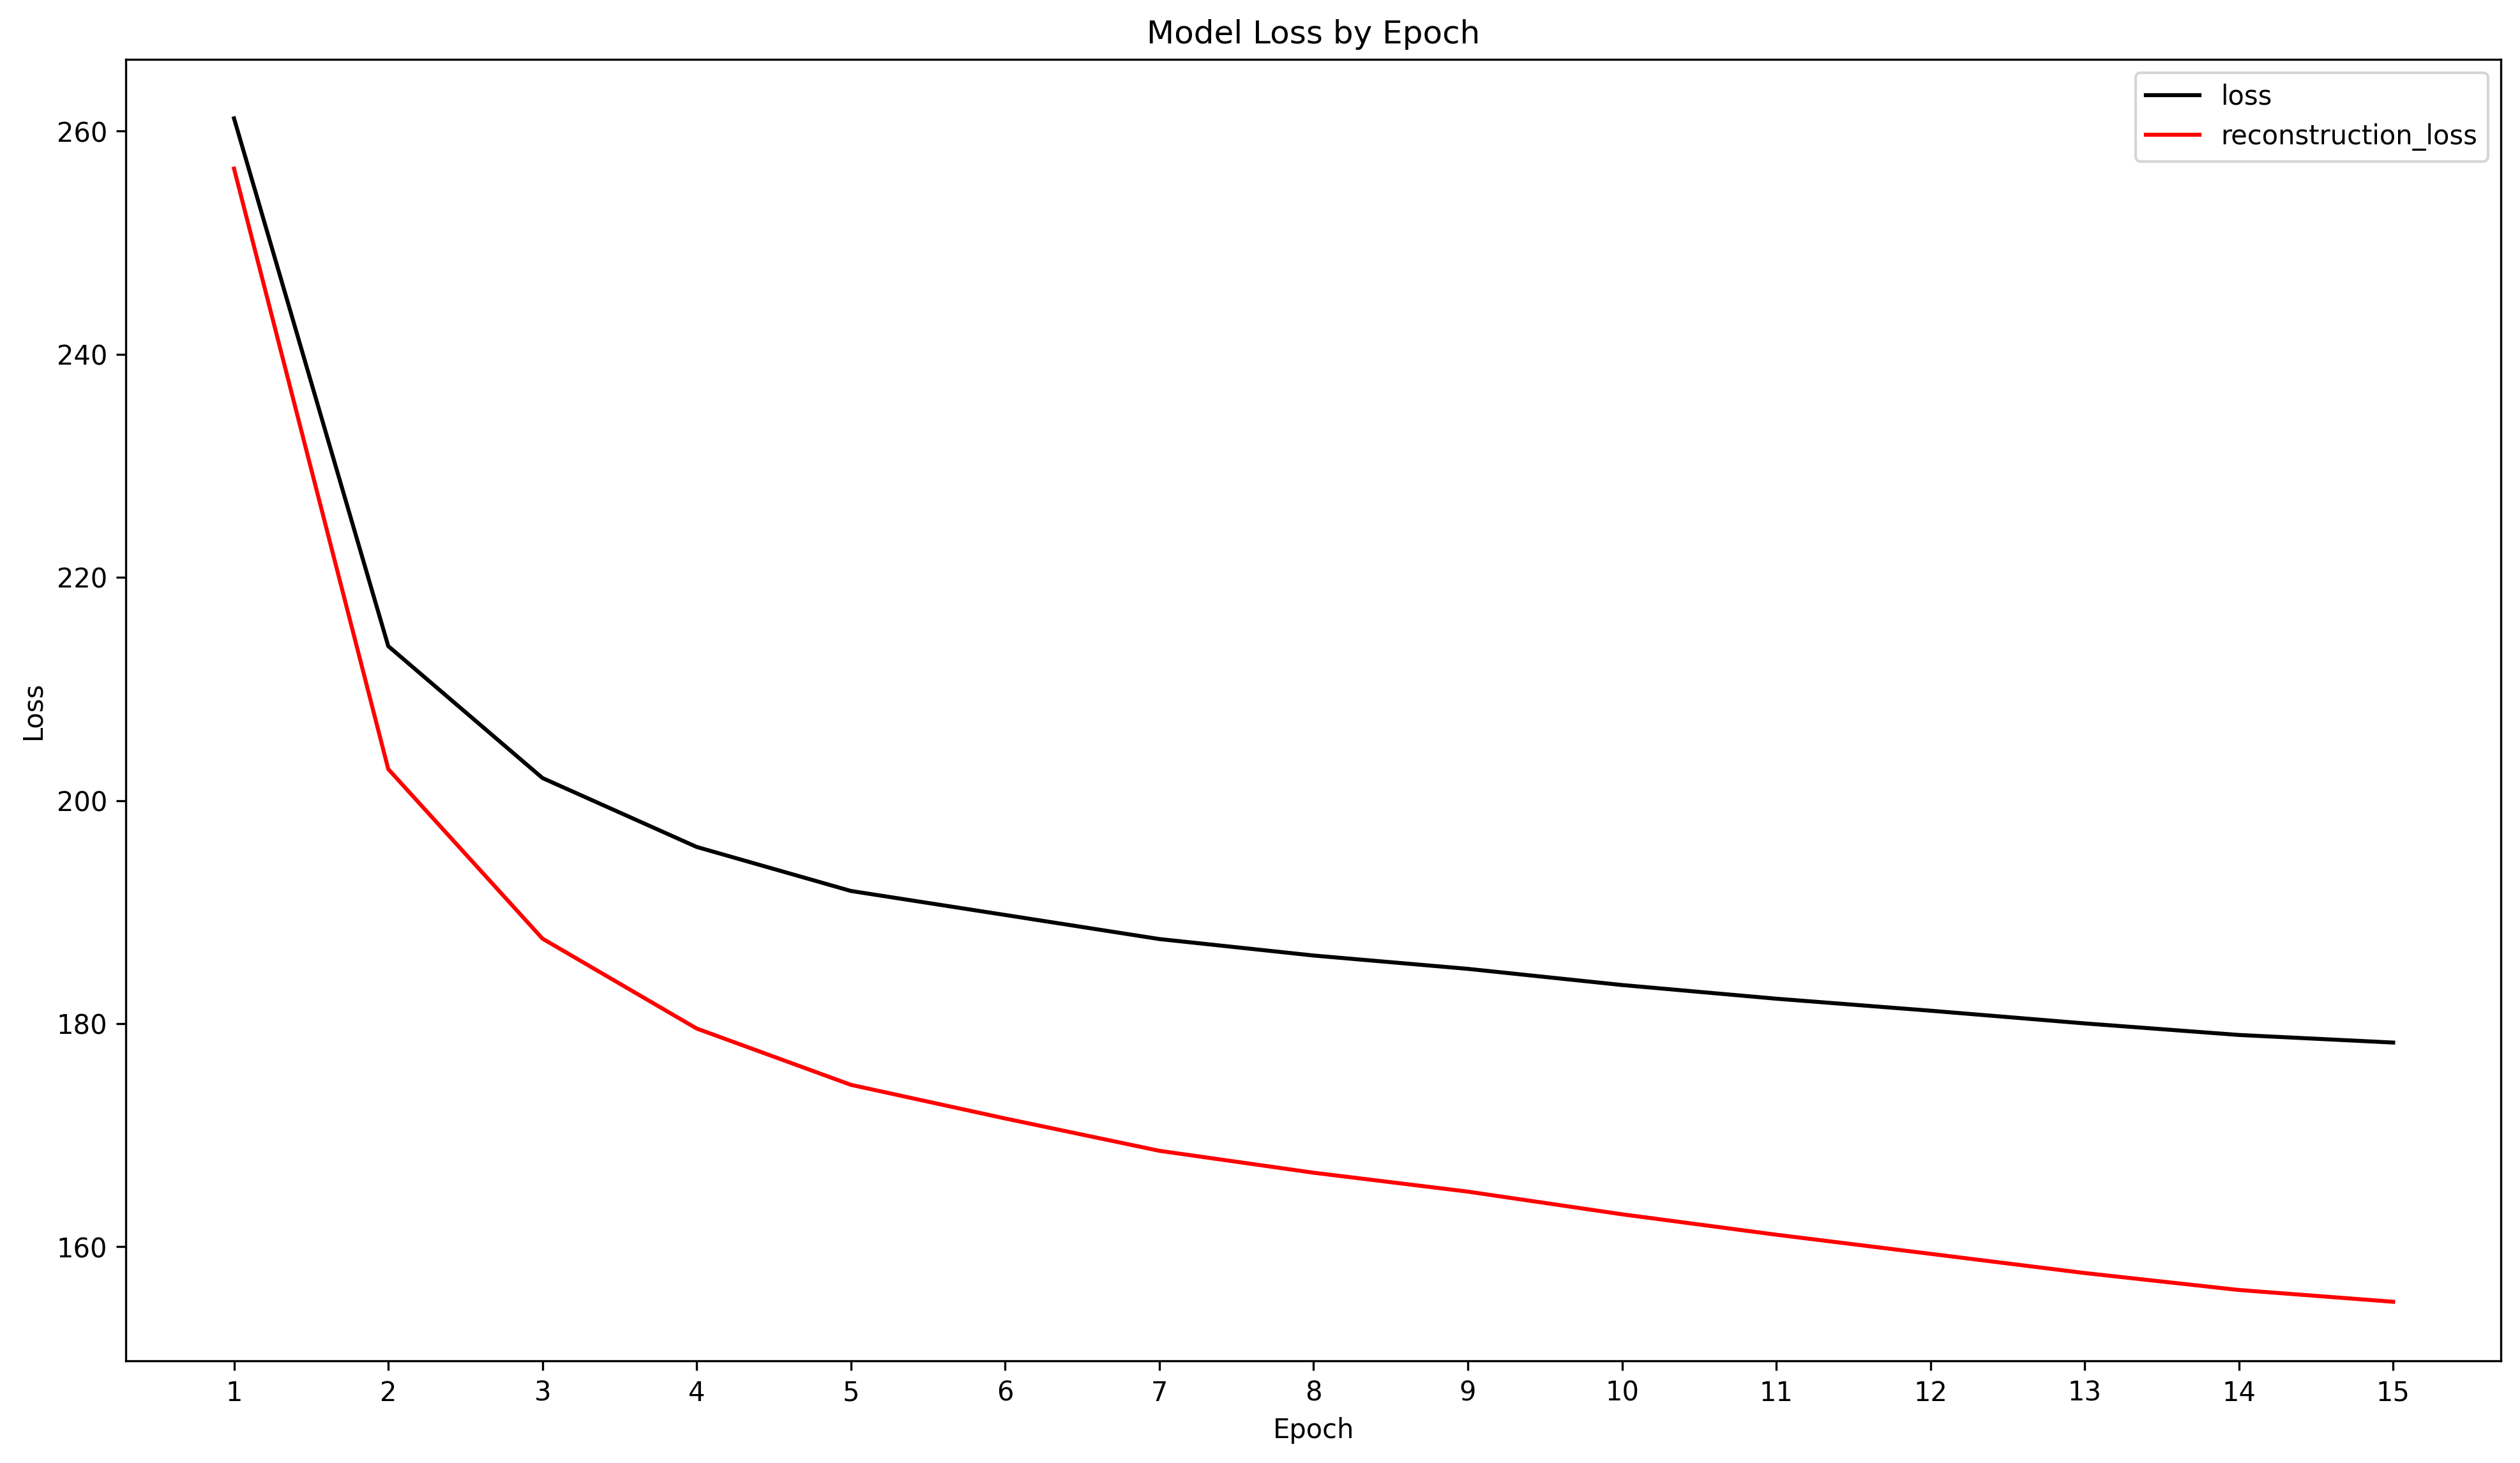

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='loss', color='black')
ax.plot(history.history['reconstruction_loss'], label='reconstruction_loss', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

<center><h3>Task 2

In [ ]:
Car = np.load('/content/drive/MyDrive/ML/Asg6/full_numpy_bitmap_car.npy')[:100].reshape((100,28,28,1))
AircraftCarrier = np.load('/content/drive/MyDrive/ML/Asg6/full_numpy_bitmap_aircraft carrier.npy')[:100].reshape((100,28,28,1))
Bicycle = np.load('/content/drive/MyDrive/ML/Asg6/full_numpy_bitmap_bicycle.npy')[:100].reshape((100,28,28,1))
Bus = np.load('/content/drive/MyDrive/ML/Asg6/full_numpy_bitmap_bus.npy')[:100].reshape((100,28,28,1))
Truck = np.load('/content/drive/MyDrive/ML/Asg6/full_numpy_bitmap_truck.npy')[:100].reshape((100,28,28,1))



Car = Car.astype('float32')/255
AircraftCarrier = AircraftCarrier.astype('float32')/255
Bicycle = Bicycle.astype('float32')/255
Bus = Bus.astype('float32')/255
Truck = Truck.astype('float32')/255

Car_LP = encoder.predict(Car)[2]
AircraftCarrier_LP = encoder.predict(AircraftCarrier)[2]
Bus_LP = encoder.predict(Bus)[2]
Bicycle_LP = encoder.predict(Bicycle)[2]
Truck_LP = encoder.predict(Truck)[2]

Car_LP = Car_LP[:100]
AircraftCarrier_LP = AircraftCarrier_LP[:100]
Bus_LP = Bus_LP[:100]
Bicycle_LP = Bicycle_LP[:100]
Truck_LP = Truck_LP[:100]

4/4 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 13ms/step


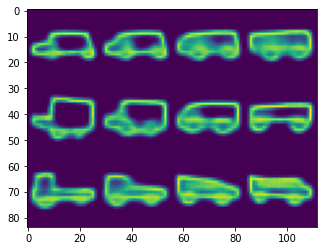

In [ ]:
import random
import copy
import matplotlib.pyplot as plt
for a_ in range(3):
  i, j = random.randint(0, 100000)%100, random.randint(0, 100000)%100
  for a in range(0, 11, 3):
    alpha = a/10
    if(a==0):
      b=255*decoder.predict(alpha*Bus_LP[i:i+1]+(1-alpha)*Truck_LP[j:j+1]).reshape((28,28))
    else:
      b=np.concatenate([b, 255*decoder.predict(alpha*Bus_LP[i:i+1]+(1-alpha)*Truck_LP[j:j+1]).reshape((28,28))], 1)
  if(a_==0):
    b_ = copy.deepcopy(b)
  else:
    b_ = np.concatenate([b_, copy.deepcopy(b)], 0)

plt.imshow(b_)

1/1 [==============================] - 0s 16ms/step


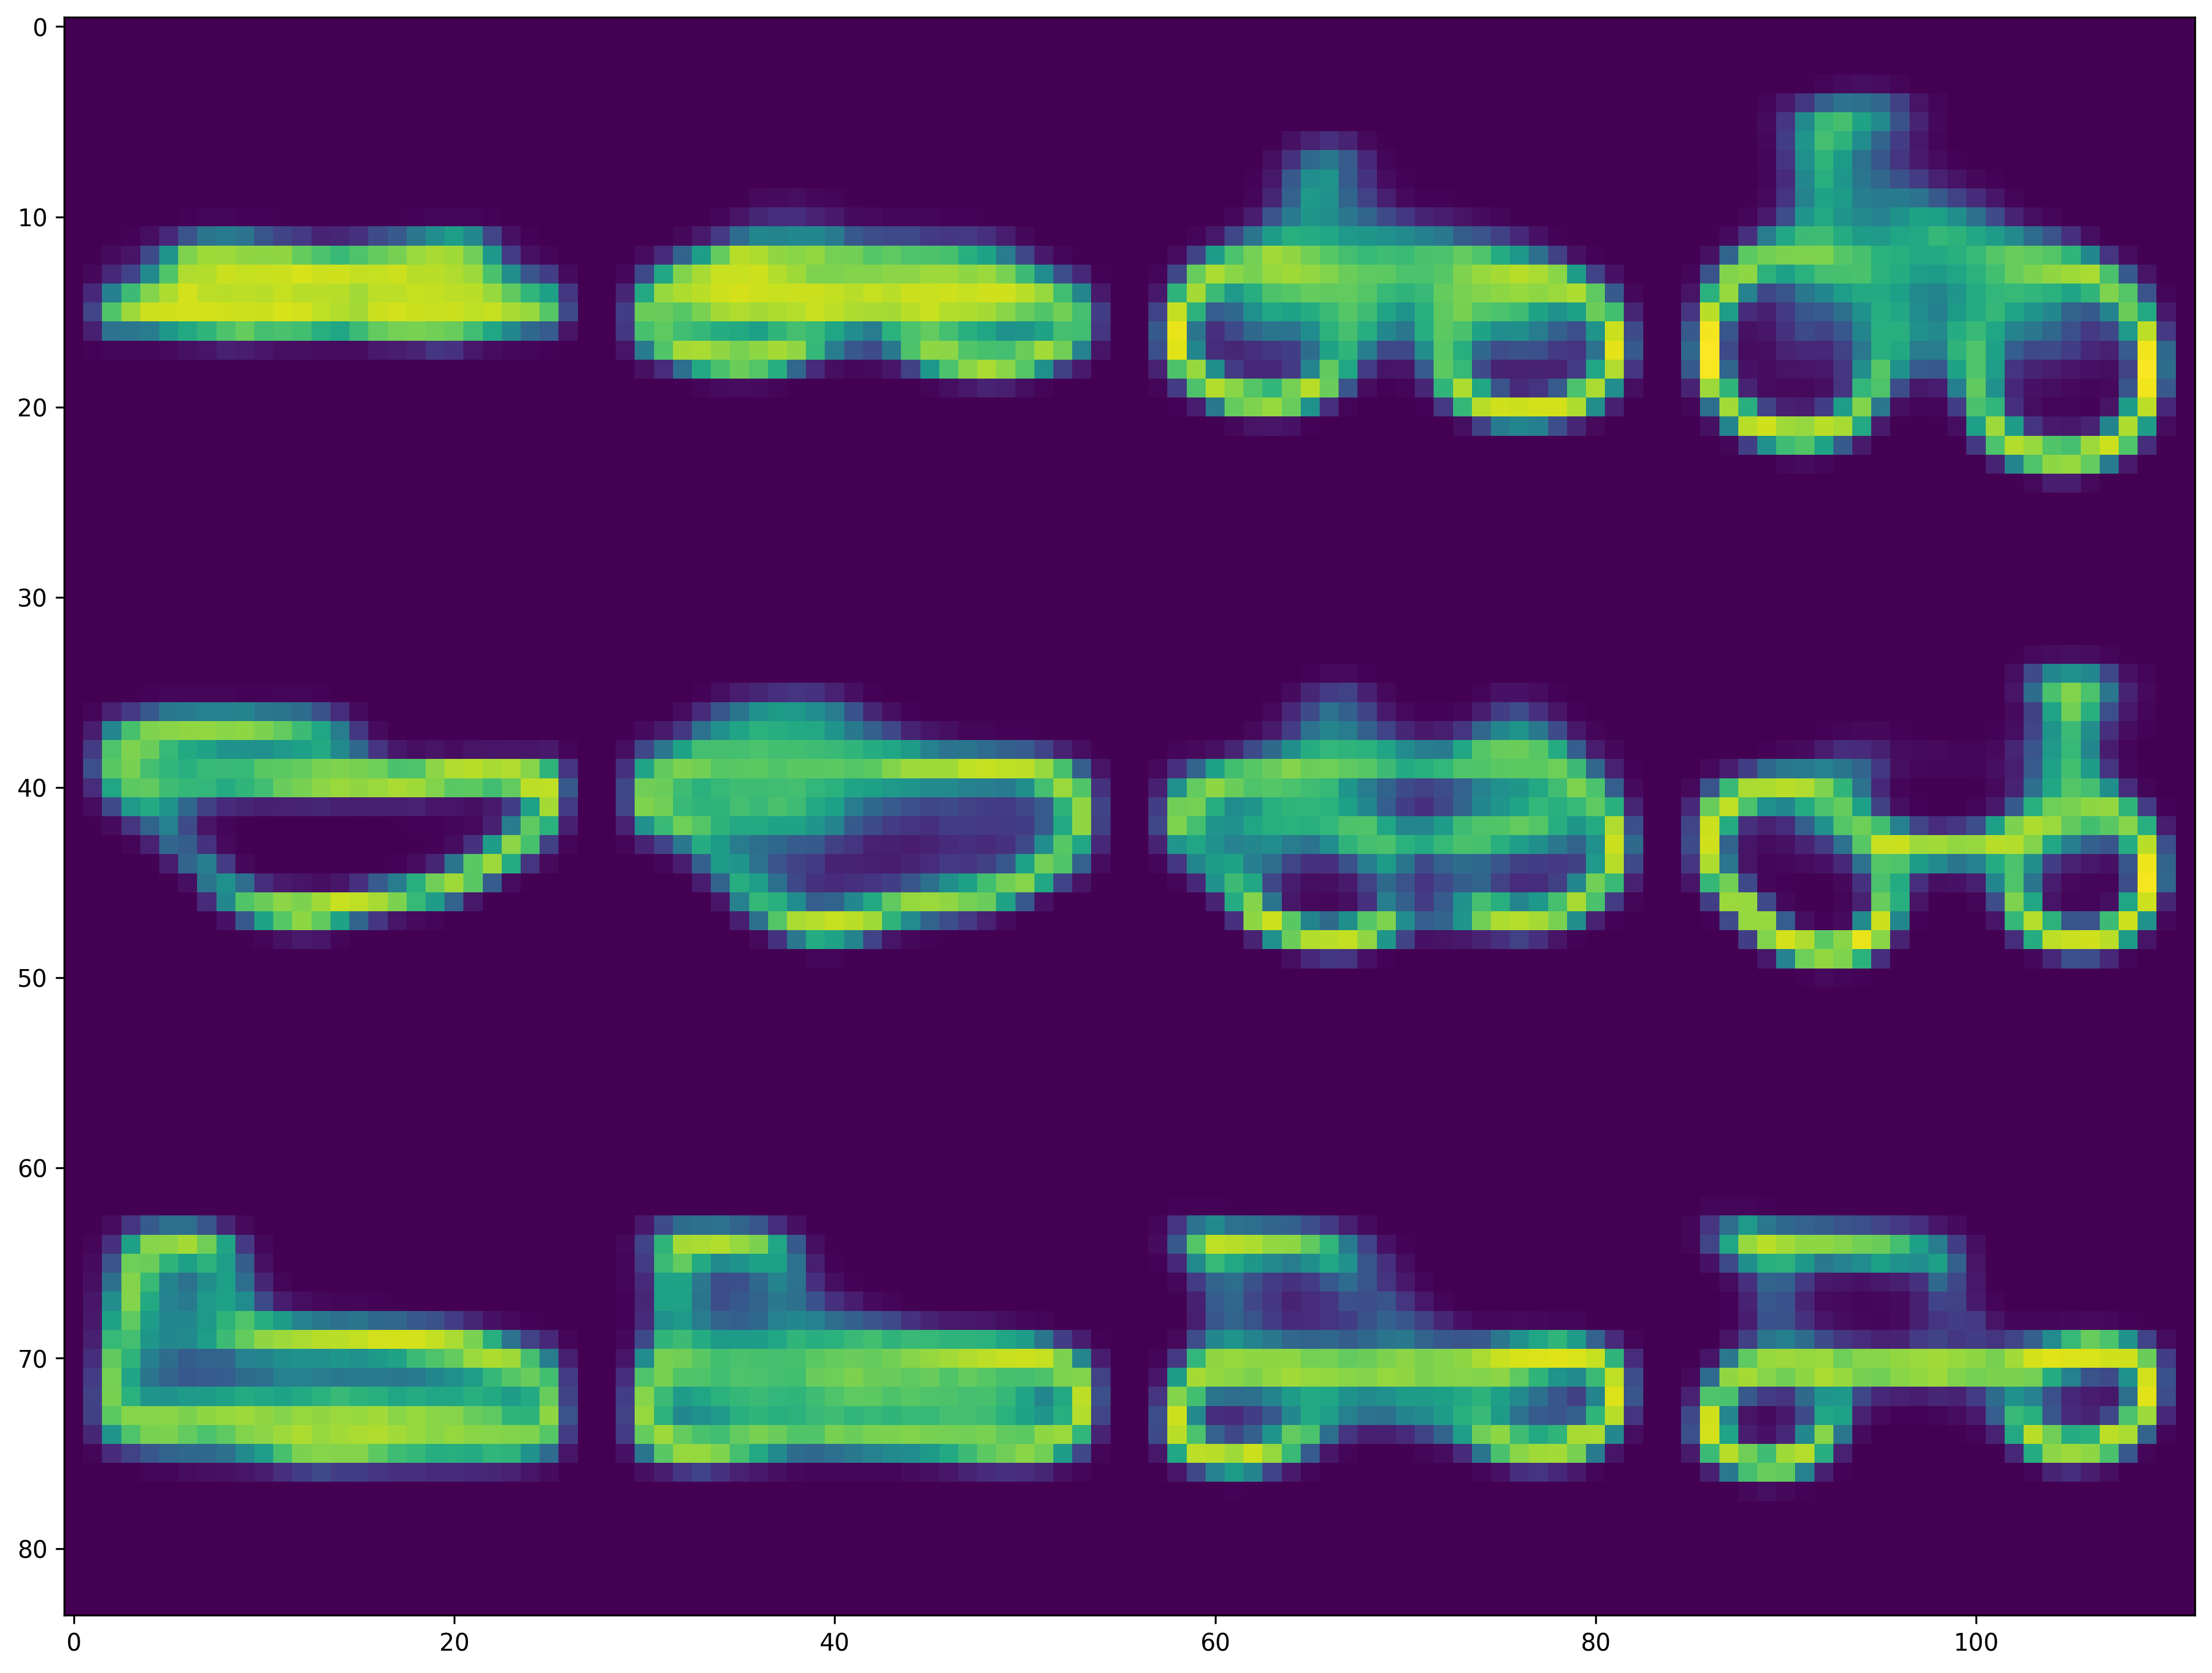

In [ ]:
import random
import copy
for a_ in range(3):
  i, j = random.randint(0, 100000)%100, random.randint(0, 100000)%100
  for a in range(0, 11, 3):
    alpha = a/10
    if(a==0):
      b=255*decoder.predict(alpha*Bicycle_LP[i:i+1]+(1-alpha)*AircraftCarrier_LP[j:j+1]).reshape((28,28))
    else:
      b=np.concatenate([b, 255*decoder.predict(alpha*Bicycle_LP[i:i+1]+(1-alpha)*AircraftCarrier_LP[j:j+1]).reshape((28,28))], 1)
  if(a_==0):
    b_ = copy.deepcopy(b)
  else:
    b_ = np.concatenate([b_, copy.deepcopy(b)], 0)

fig, ax = plt.subplots(figsize=(16,16), dpi=300)
plt.imshow(b_)

1/1 [==============================] - 0s 27ms/step


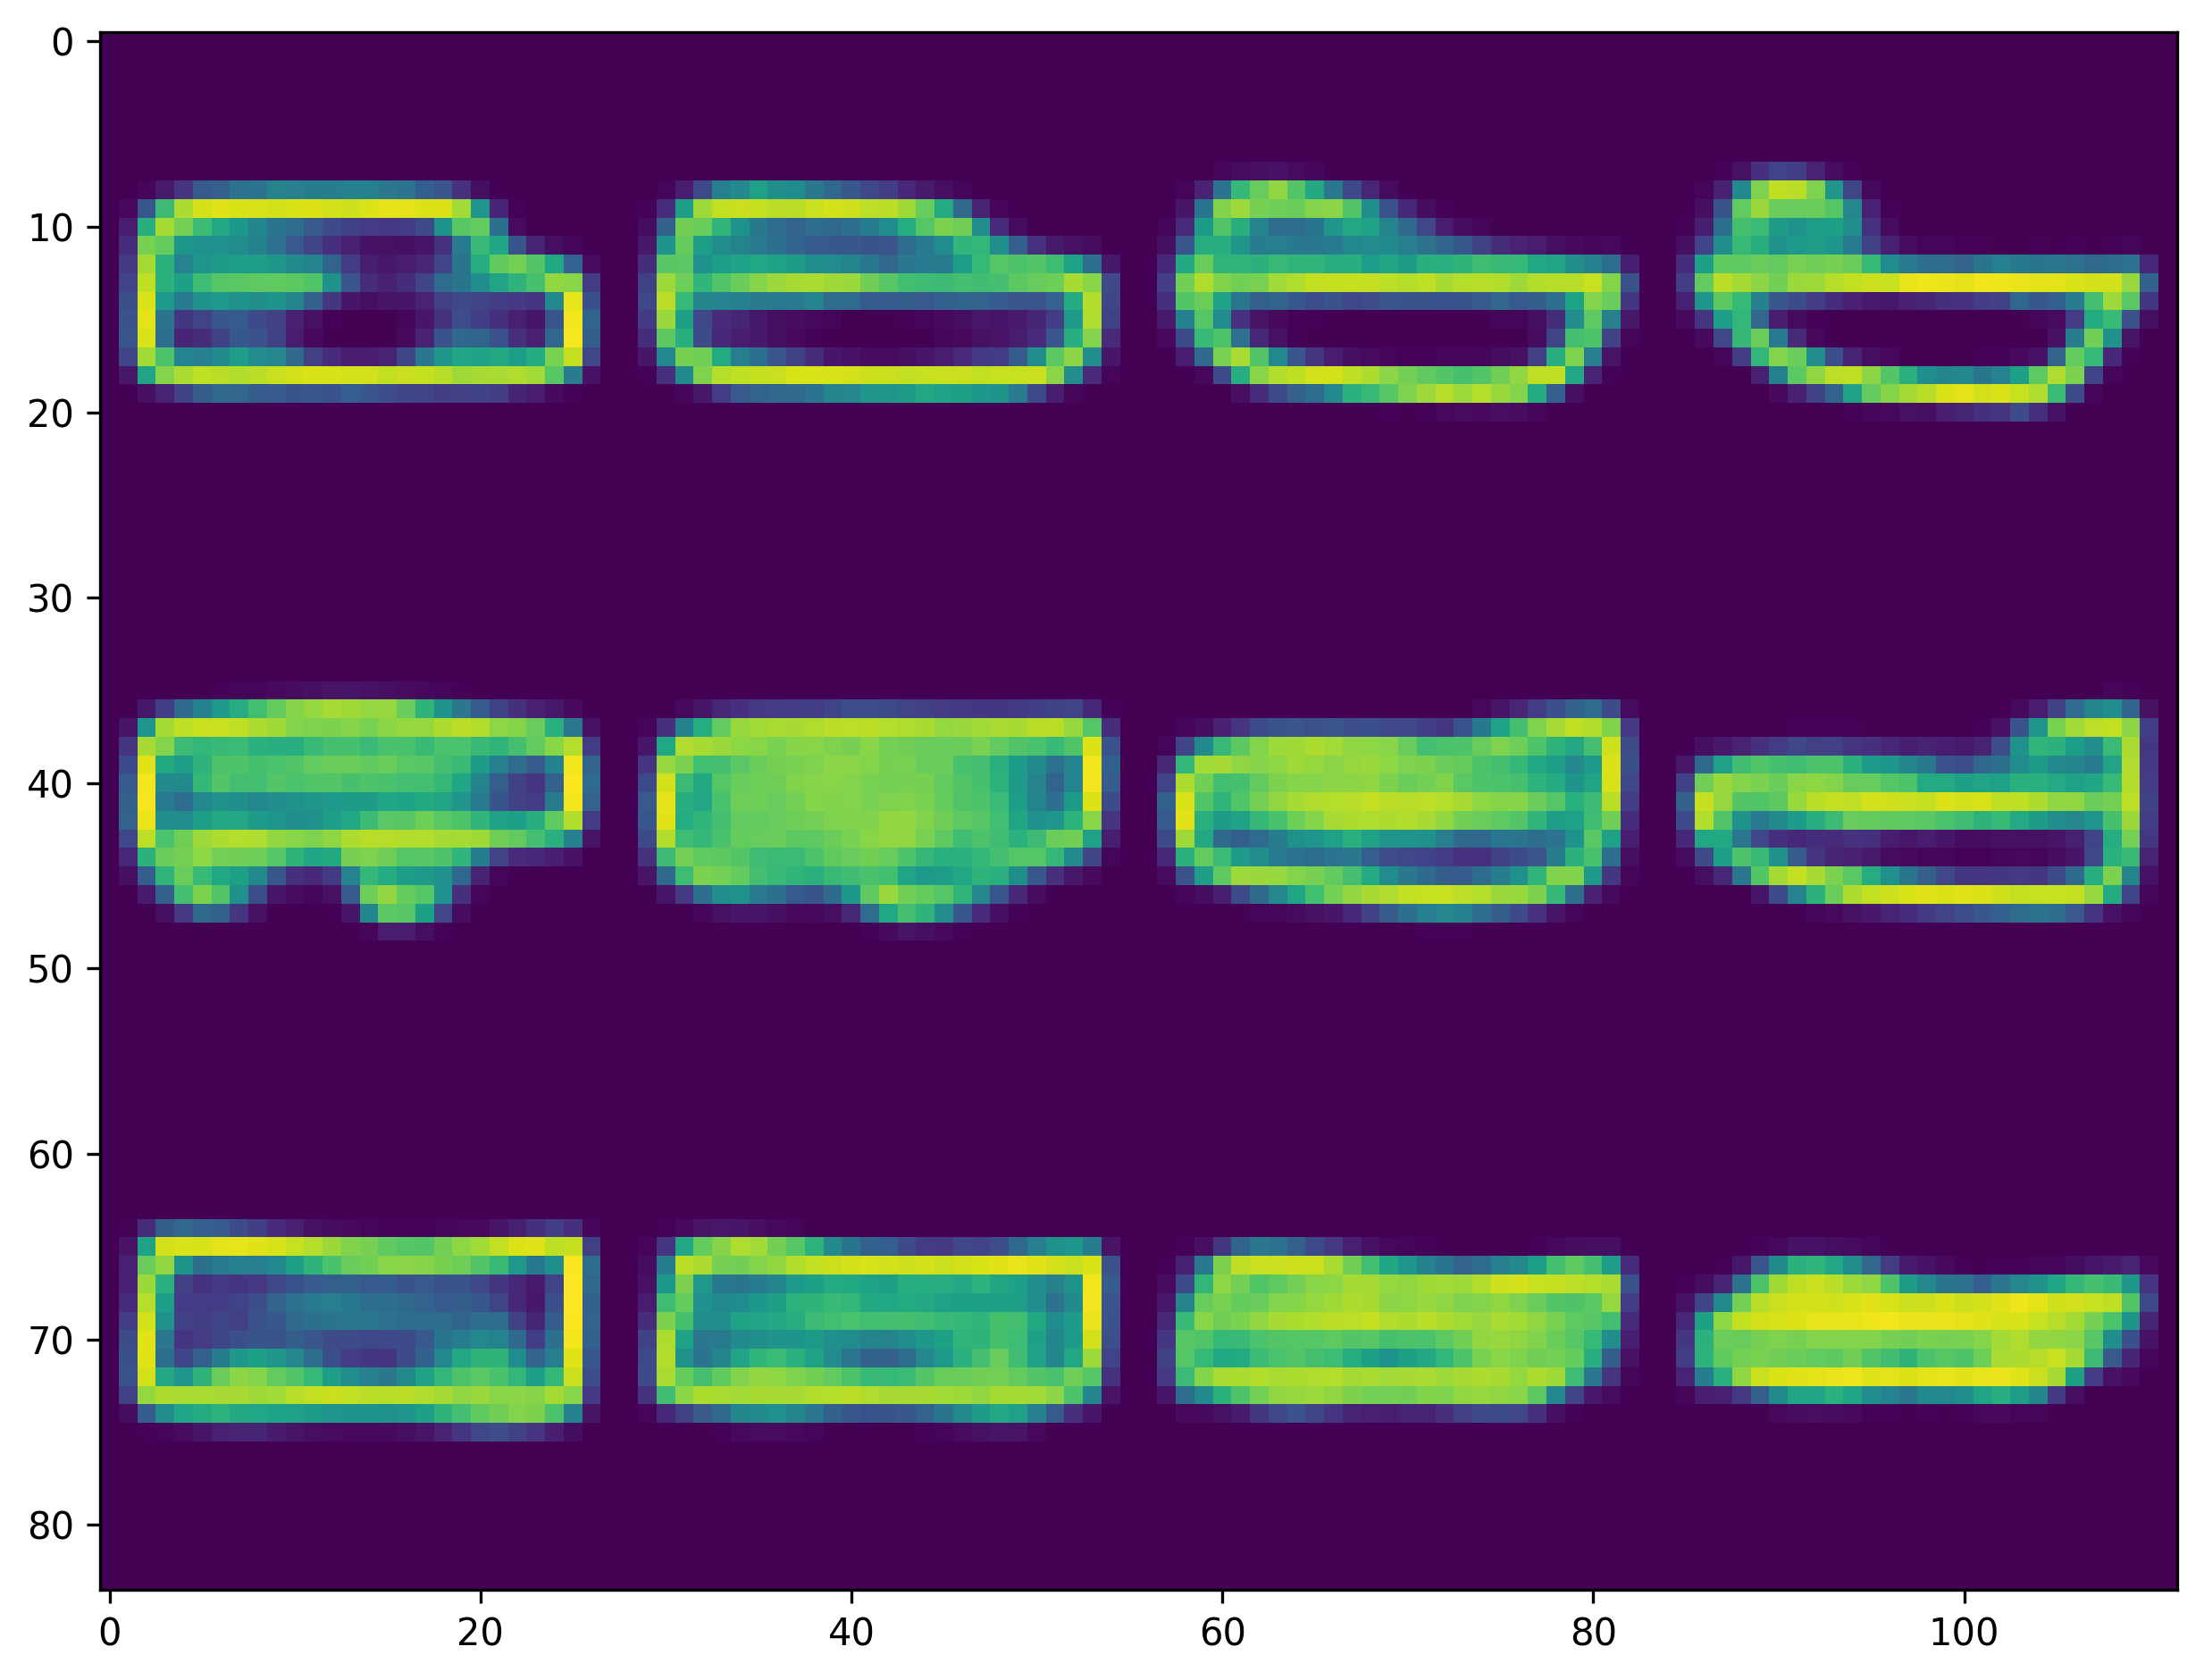

In [ ]:
import random
import copy
for a_ in range(3):
  i, j = random.randint(0, 100000)%100, random.randint(0, 100000)%100
  for a in range(0, 11, 3):
    alpha = a/10
    if(a==0):
      b=255*decoder.predict(alpha*AircraftCarrier_LP[i:i+1]+(1-alpha)*Bus_LP[j:j+1]).reshape((28,28))
    else:
      b=np.concatenate([b, 255*decoder.predict(alpha*AircraftCarrier_LP[i:i+1]+(1-alpha)*Bus_LP[j:j+1]).reshape((28,28))], 1)
  if(a_==0):
    b_ = copy.deepcopy(b)
  else:
    b_ = np.concatenate([b_, copy.deepcopy(b)], 0)

fig, ax = plt.subplots(figsize=(16,10), dpi=300)
plt.imshow(b_)

1/1 [==============================] - 0s 16ms/step


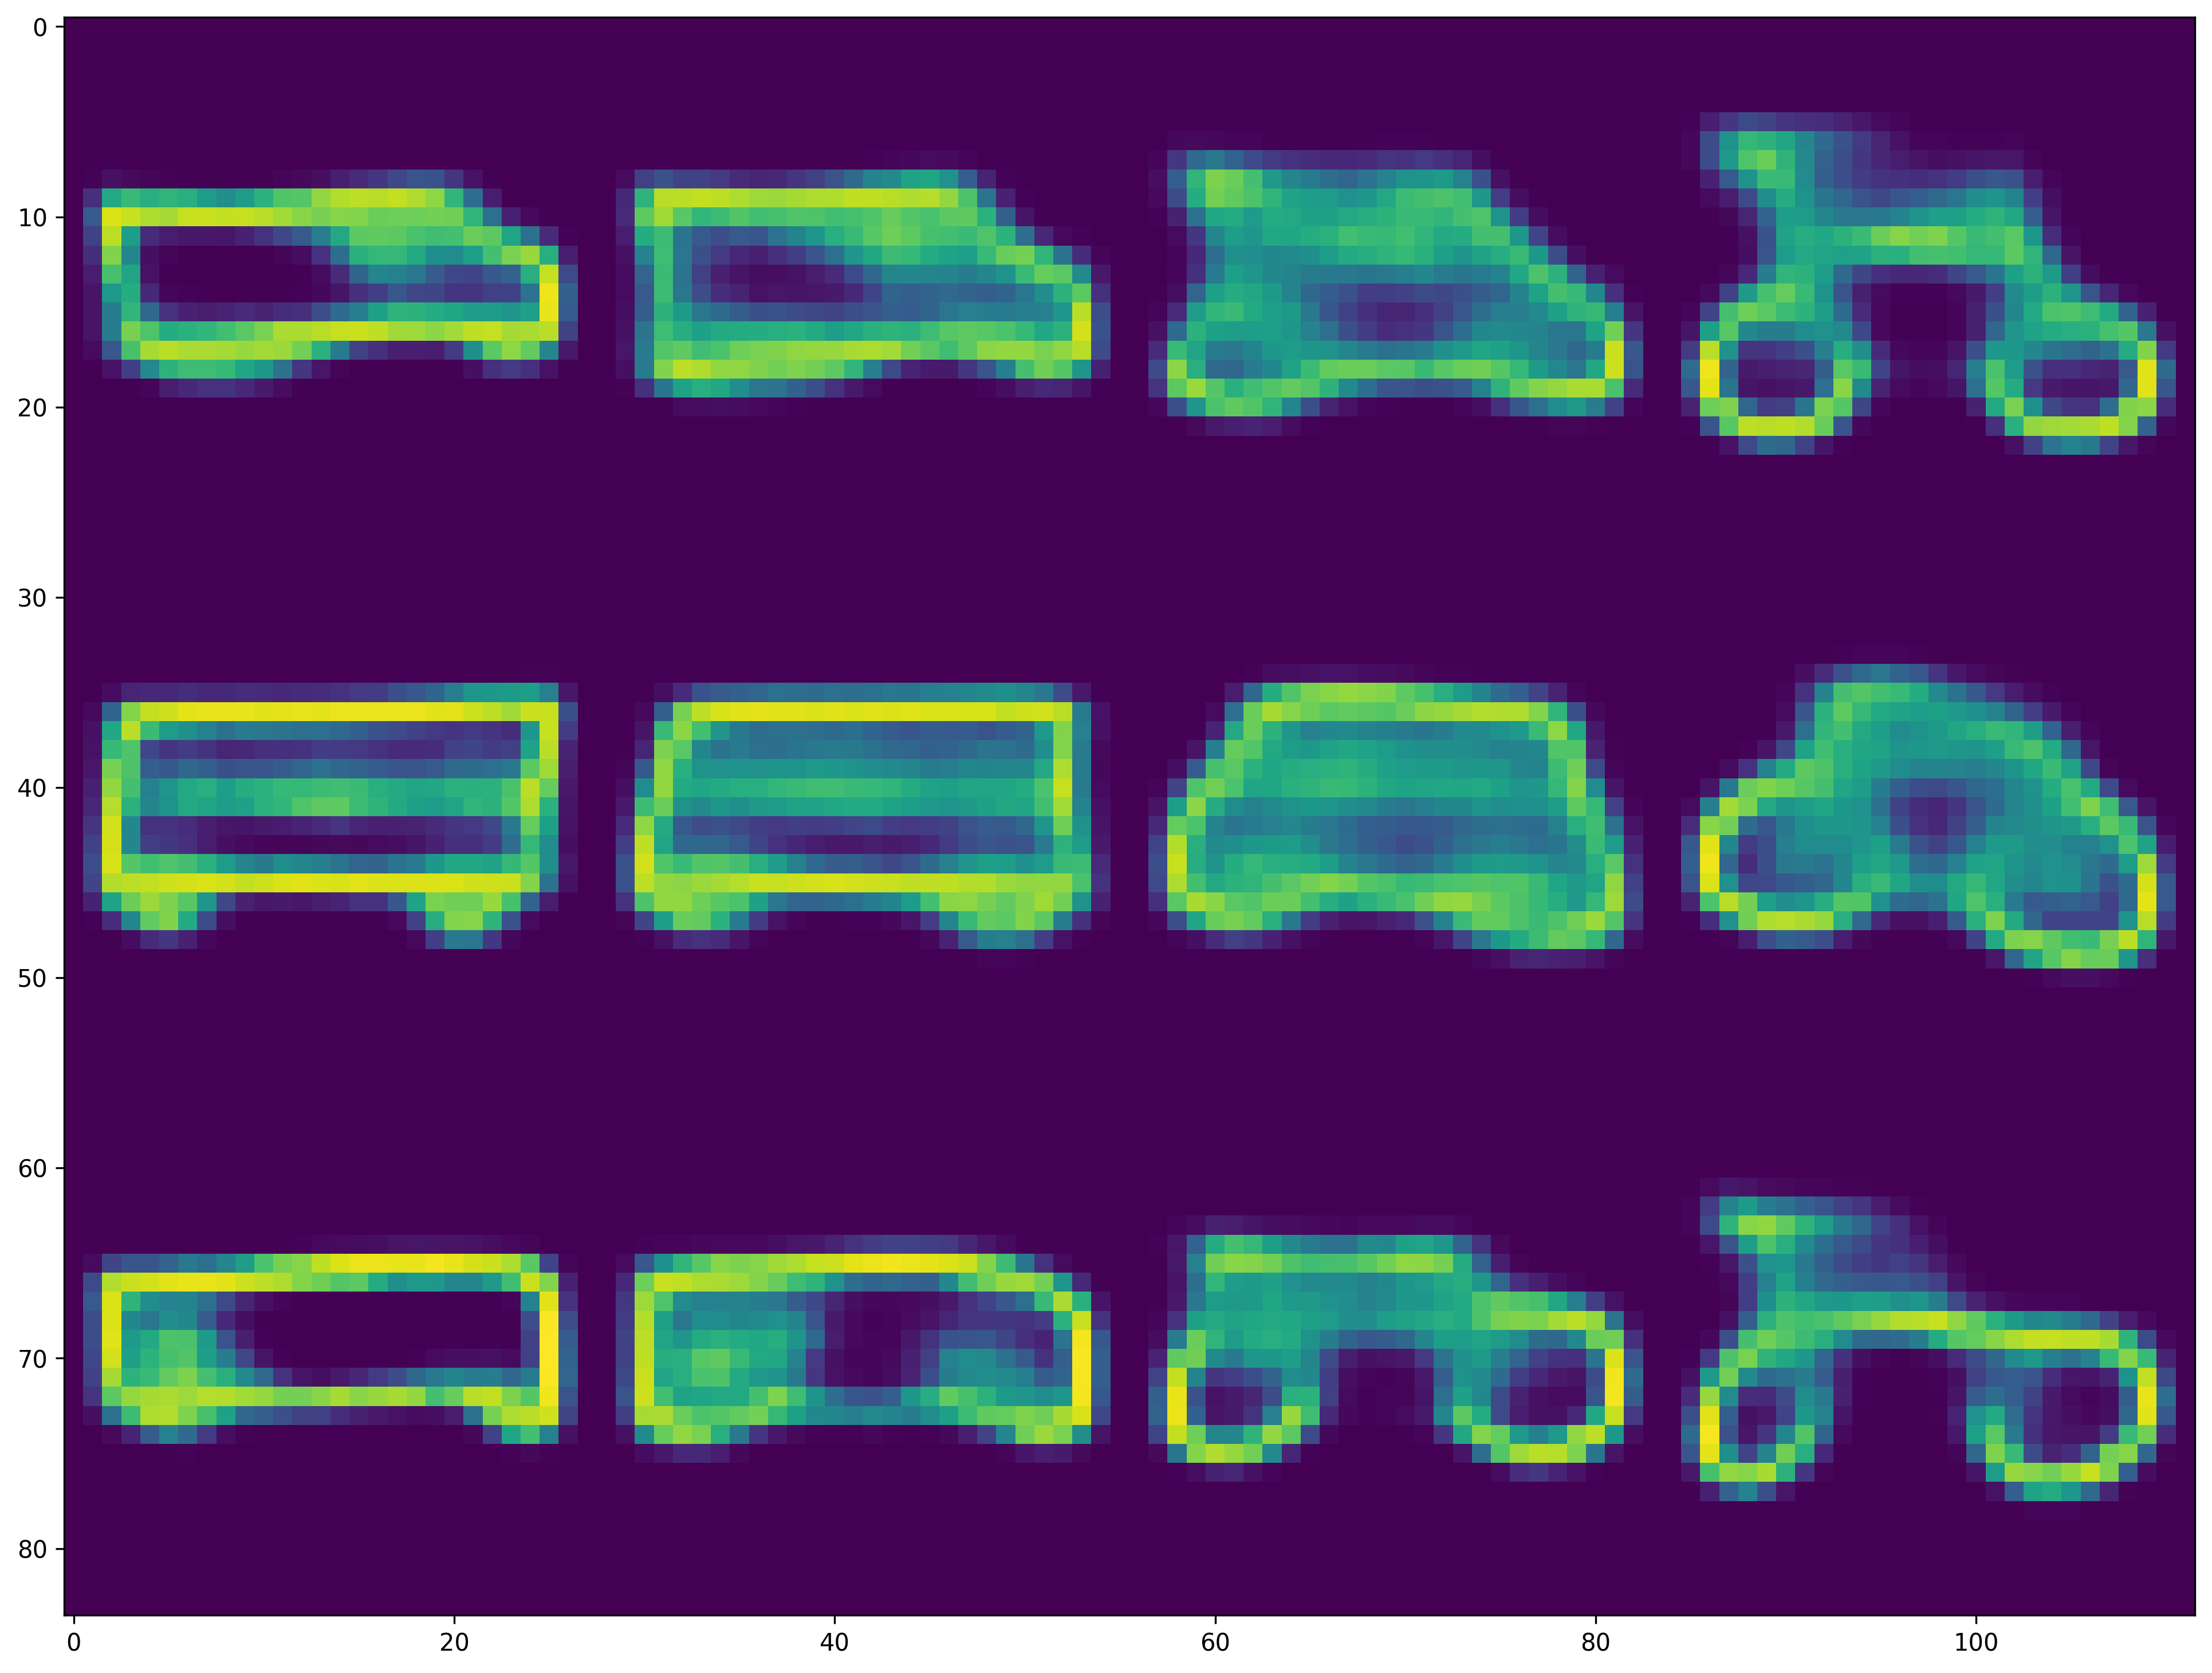

In [ ]:
import random
import copy
for a_ in range(3):
  i, j = random.randint(0, 100000)%100, random.randint(0, 100000)%100
  for a in range(0, 11, 3):
    alpha = a/10
    if(a==0):
      b=255*decoder.predict(alpha*Bicycle_LP[i:i+1]+(1-alpha)*Bus_LP[j:j+1]).reshape((28,28))
    else:
      b=np.concatenate([b, 255*decoder.predict(alpha*Bicycle_LP[i:i+1]+(1-alpha)*Bus_LP[j:j+1]).reshape((28,28))], 1)
  if(a_==0):
    b_ = copy.deepcopy(b)
  else:
    b_ = np.concatenate([b_, copy.deepcopy(b)], 0)

fig, ax = plt.subplots(figsize=(16,16), dpi=300)
plt.imshow(b_)

<center><h3>Task 3

Which categories you want to design
1,5
Percentage of interpolation: 80
1/1 [==============================] - 0s 14ms/step


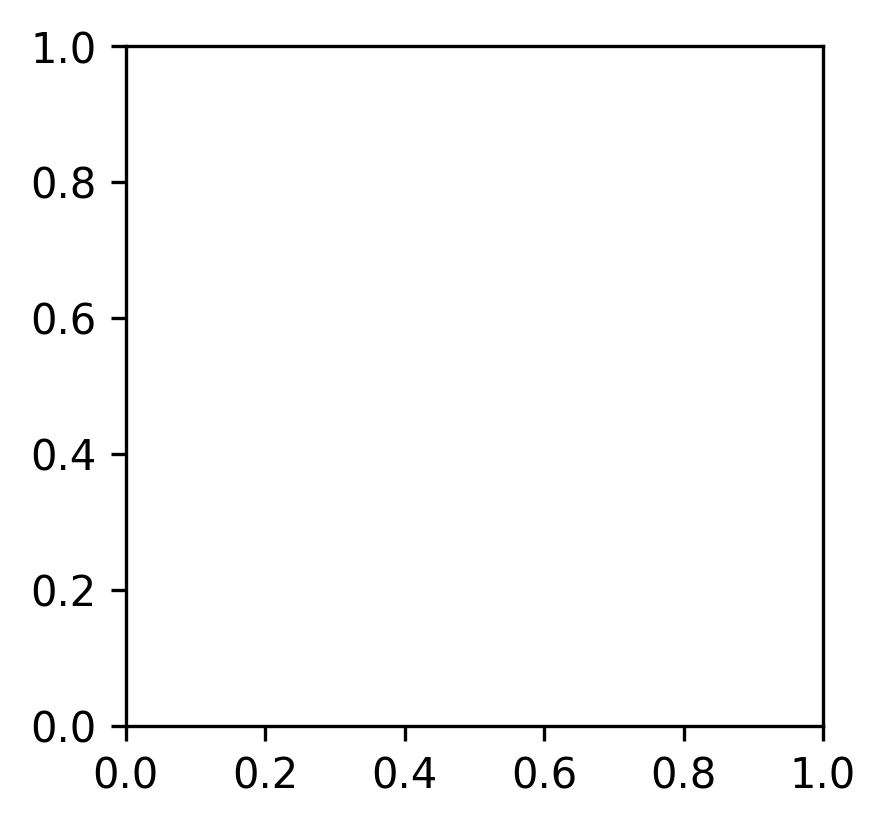

In [ ]:
print('Which categories you want to design')
a1, a2 = eval(input())
dit = {
    1: 'Airplane_LP',
    2: 'Bus_LP',
    3: 'Bicycle_LP',
    4: 'Truck_LP',
    5: 'Car_LP'
}
t1 = eval(input('Percentage of interpolation: '))/100

for p in range(5):
  i, j = random.randint(0, 100000)%100, random.randint(0, 100000)%100
  b=255*decoder.predict(t1*Bus_LP[i:i+1]+(1-t1)*Truck_LP[j:j+1]).reshape((28,28))
  b_ = copy.deepcopy(b)
  
fig, ax = plt.subplots(figsize=(3,3), dpi=300)


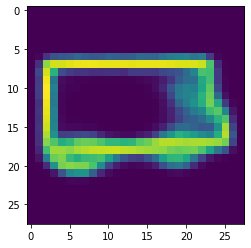

In [ ]:
plt.imshow(b_)